In [1]:
import numpy as np
import json
from scipy.stats import pearsonr
from tqdm import tqdm
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()
dataset_path = os.getenv("DATASET_PATH")

### Loading audio & motion features

In [3]:
instruments = ["vocal", "mridangam", "violin"]
motion_features = {}
audio_features = {}

for artist in tqdm(os.listdir(dataset_path), desc="Artists"):
    artist_dir = os.path.join(dataset_path, artist)
    if not os.path.isdir(artist_dir) or artist.startswith("."):
        continue

    motion_features.setdefault(artist, {})
    audio_features.setdefault(artist, {})

    for song in tqdm(os.listdir(artist_dir), desc="Songs", leave=False):
        song_dir = os.path.join(artist_dir, song)
        if not os.path.isdir(song_dir) or song.startswith("."):
            continue

        motion_features[artist].setdefault(song, {})
        audio_features[artist].setdefault(song, {})

        for instrument in instruments:
            instrument_dir = os.path.join(song_dir, instrument)
            if not os.path.exists(instrument_dir):
                continue

            motion_features[artist][song].setdefault(instrument, {})
            audio_features[artist][song].setdefault(instrument, {})

            try:
                with open(
                    os.path.join(instrument_dir, "motion_features.json"), "r"
                ) as f:
                    motion_features[artist][song][instrument] = json.load(f)
                with open(
                    os.path.join(instrument_dir, "audio_features.json"), "r"
                ) as f:
                    audio_features[artist][song][instrument] = json.load(f)
            except FileNotFoundError:
                print(
                    f"File not found for {artist}/{song}/{instrument}. Skipping this instrument."
                )
                continue

Artists: 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


In [4]:
def safe_pearsonr(x, y):
    """
    Compute Pearson correlation between x and y, ignoring NaNs.

    Returns (corr, pval). If too few valid values, returns (np.nan, np.nan).
    """
    x = np.array(x)
    y = np.array(y)
    mask = ~np.isnan(x) & ~np.isnan(y)
    if np.sum(mask) < 2:  # need at least 2 points to compute correlation
        return np.nan, np.nan
    return pearsonr(x[mask], y[mask])

### Global speed & acceleration vs gesture correlations 

In [5]:
speed_relevant_correlations = []

for artist in motion_features.keys():
    for song in motion_features[artist].keys():
        for instrument in motion_features[artist][song].keys():
            for body_part in motion_features[artist][song][instrument].keys():
                try:
                    corr, pval = safe_pearsonr(
                        motion_features[artist][song][instrument][body_part][
                            "mean_acceleration"
                        ],
                        audio_features[artist][song][instrument]["onset_env"],
                    )

                    if corr > 0.25 and pval < 0.05:
                        speed_relevant_correlations.append(
                            {
                                "artist": artist,
                                "song": song,
                                "instrument": instrument,
                                "body_part": body_part,
                                "corr": float(corr),
                            }
                        )
                except Exception as e:
                    print(
                        f"Error processing {artist}, {song}, {instrument}, {body_part}: {e}"
                    )

In [6]:
speed_relevant_correlations

[{'artist': 'Abhiram Bode',
  'song': 'Nadatina',
  'instrument': 'mridangam',
  'body_part': 'general',
  'corr': 0.273663575517913},
 {'artist': 'Abhiram Bode',
  'song': 'Nadatina',
  'instrument': 'mridangam',
  'body_part': 'right_arm',
  'corr': 0.2936424407028859},
 {'artist': 'Abhiram Bode',
  'song': 'Nadatina',
  'instrument': 'mridangam',
  'body_part': 'right_hand',
  'corr': 0.2933689556330913},
 {'artist': 'Abhiram Bode',
  'song': 'Devi Pavane',
  'instrument': 'mridangam',
  'body_part': 'general',
  'corr': 0.25933998420450166},
 {'artist': 'Abhiram Bode',
  'song': 'Devi Pavane',
  'instrument': 'mridangam',
  'body_part': 'right_arm',
  'corr': 0.25044832298758957},
 {'artist': 'Abhiram Bode',
  'song': 'Devi Pavane',
  'instrument': 'mridangam',
  'body_part': 'right_hand',
  'corr': 0.3135908005327031}]

In [7]:
acceleration_relevant_correlations = []

for artist in motion_features.keys():
    for song in motion_features[artist].keys():
        for instrument in motion_features[artist][song].keys():
            for body_part in motion_features[artist][song][instrument].keys():
                try:
                    corr, pval = safe_pearsonr(
                        motion_features[artist][song][instrument][body_part][
                            "mean_acceleration"
                        ],
                        audio_features[artist][song][instrument]["onset_env"],
                    )

                    if corr > 0.25 and pval < 0.05:
                        acceleration_relevant_correlations.append(
                            {
                                "artist": artist,
                                "song": song,
                                "instrument": instrument,
                                "body_part": body_part,
                                "corr": float(corr),
                            }
                        )
                except Exception as e:
                    print(
                        f"Error processing {artist}, {song}, {instrument}, {body_part}: {e}"
                    )

In [8]:
acceleration_relevant_correlations

[{'artist': 'Abhiram Bode',
  'song': 'Nadatina',
  'instrument': 'mridangam',
  'body_part': 'general',
  'corr': 0.273663575517913},
 {'artist': 'Abhiram Bode',
  'song': 'Nadatina',
  'instrument': 'mridangam',
  'body_part': 'right_arm',
  'corr': 0.2936424407028859},
 {'artist': 'Abhiram Bode',
  'song': 'Nadatina',
  'instrument': 'mridangam',
  'body_part': 'right_hand',
  'corr': 0.2933689556330913},
 {'artist': 'Abhiram Bode',
  'song': 'Devi Pavane',
  'instrument': 'mridangam',
  'body_part': 'general',
  'corr': 0.25933998420450166},
 {'artist': 'Abhiram Bode',
  'song': 'Devi Pavane',
  'instrument': 'mridangam',
  'body_part': 'right_arm',
  'corr': 0.25044832298758957},
 {'artist': 'Abhiram Bode',
  'song': 'Devi Pavane',
  'instrument': 'mridangam',
  'body_part': 'right_hand',
  'corr': 0.3135908005327031}]

### Local speed & acceleration vs gesture correlations

In [9]:
fps = 30


def sliding_correlation(
    signal1, signal2, window_size, step_size, threshold=0.3
):
    assert len(signal1) == len(signal2), "Signals must be the same length"

    correlations = []
    pvals = []
    times = []
    for start in range(0, len(signal1) - window_size + 1, step_size):
        end = start + window_size
        seg1 = signal1[start:end]
        seg2 = signal2[start:end]

        corr, pval = safe_pearsonr(seg1, seg2)
        correlations.append(corr)
        pvals.append(pval)
        times.append(start / fps)

    strong_corr_times = [
        t
        for t, c, p in zip(times, correlations, pvals)
        if not np.isnan(p)
        and p < 0.05
        and not np.isnan(c)
        and abs(c) > threshold
    ]

    return np.array(correlations), np.array(times), strong_corr_times

In [10]:
window_size = int(0.5 * fps)
step_size = int(0.1 * fps)

strong_windows = {}

for artist in motion_features.keys():
    if artist not in strong_windows:
        strong_windows[artist] = {}
    for song in motion_features[artist].keys():
        if song not in strong_windows[artist]:
            strong_windows[artist][song] = {}
        for instrument in motion_features[artist][song].keys():
            if instrument not in strong_windows[artist][song]:
                strong_windows[artist][song][instrument] = {}
            for body_part in motion_features[artist][song][instrument].keys():
                if body_part not in strong_windows[artist][song][instrument]:
                    strong_windows[artist][song][instrument][body_part] = []
                audio_feature = audio_features[artist][song][instrument][
                    "onset_env"
                ]
                speed_feature = motion_features[artist][song][instrument][
                    body_part
                ]["mean_speed"]
                correlations, times, speed_strong_windows = (
                    sliding_correlation(
                        speed_feature,
                        audio_feature,
                        window_size,
                        step_size,
                        threshold=0.5,
                    )
                )

                accel_feature = motion_features[artist][song][instrument][
                    body_part
                ]["mean_acceleration"]
                correlations, times, accel_strong_windows = (
                    sliding_correlation(
                        accel_feature,
                        audio_feature,
                        window_size,
                        step_size,
                        threshold=0.5,
                    )
                )
                strong_windows[artist][song][instrument][body_part] = {
                    "speed": speed_strong_windows,
                    "accel": accel_strong_windows,
                }

In [11]:
for artist in strong_windows.keys():
    artist_dir = os.path.join(dataset_path, artist)
    for song in strong_windows[artist].keys():
        song_dir = os.path.join(artist_dir, song)
        for instrument in strong_windows[artist][song].keys():
            instrument_dir = os.path.join(song_dir, instrument)
            instrument_file = os.path.join(
                instrument_dir, "strong_correlation_05s_windows.json"
            )
            with open(instrument_file, "w") as f:
                json.dump(
                    strong_windows[artist][song][instrument], f, indent=4
                )

print("Strong windows saved to JSON files.")

Strong windows saved to JSON files.


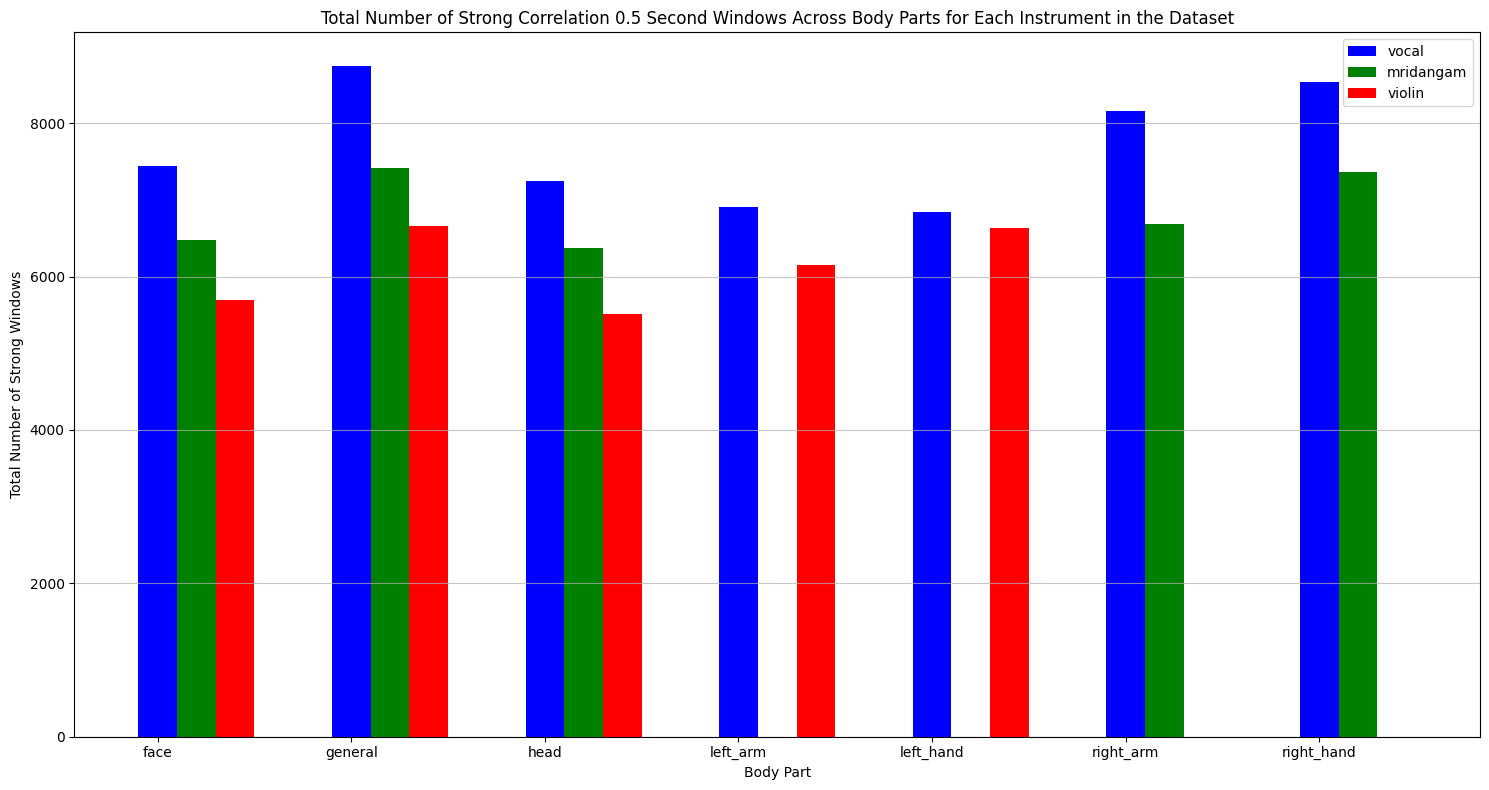

In [12]:
import matplotlib.pyplot as plt

body_parts_all = set()
body_part_counts = {instrument: {} for instrument in instruments}

# Aggregate counts across all artists and songs
for artist in strong_windows.keys():
    for song in strong_windows[artist].keys():
        for instrument in strong_windows[artist][song].keys():
            for body_part in strong_windows[artist][song][instrument].keys():
                speed_count = len(
                    strong_windows[artist][song][instrument][body_part][
                        "speed"
                    ]
                )
                accel_count = len(
                    strong_windows[artist][song][instrument][body_part][
                        "accel"
                    ]
                )
                total_count = speed_count + accel_count

                body_part_name = body_part
                body_parts_all.add(body_part_name)
                if body_part_name not in body_part_counts[instrument]:
                    body_part_counts[instrument][body_part_name] = 0
                body_part_counts[instrument][body_part_name] += total_count

# Prepare data for plotting
body_parts_list = sorted(list(body_parts_all))
num_body_parts = len(body_parts_list)
x = np.arange(num_body_parts)
width = 0.2  # Width of each bar

plt.figure(figsize=(15, 8))

colors = ["blue", "green", "red"]  # Colors for each instrument

for i, instrument in enumerate(instruments):
    counts = [
        body_part_counts[instrument].get(part, 0) for part in body_parts_list
    ]
    plt.bar(
        x + (i * width), counts, width=width, label=instrument, color=colors[i]
    )

plt.xlabel("Body Part")
plt.ylabel("Total Number of Strong Windows")
plt.title(
    "Total Number of Strong Correlation 0.5 Second Windows Across Body Parts for Each Instrument in the Dataset"
)
plt.xticks(x, body_parts_list)  # Set x-axis labels and rotate
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.grid(axis="y", alpha=0.7)
plt.legend()
plt.show()

### Cross-Correlation Study

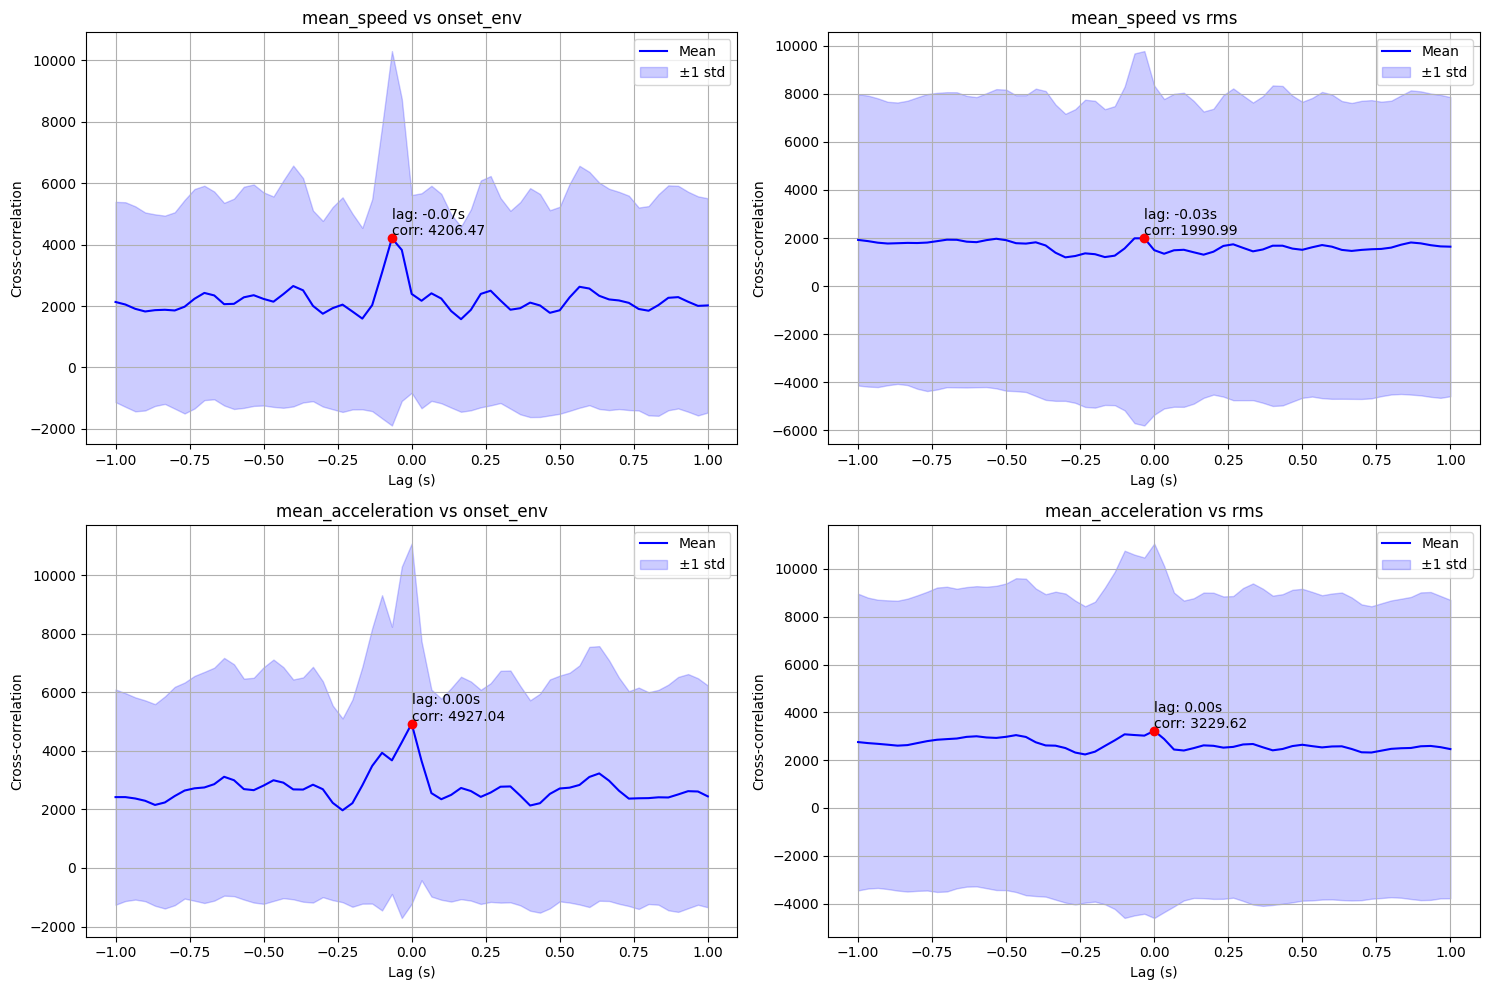

In [13]:
from scipy.signal import correlate
import matplotlib.pyplot as plt
import numpy as np

feature_pairs = [
    ("mean_speed", "onset_env"),
    ("mean_speed", "rms"),
    ("mean_acceleration", "onset_env"),
    ("mean_acceleration", "rms"),
]

max_lag = fps  # 30 frames = 1 s
lags = np.arange(-max_lag, max_lag + 1)

# Initialize arrays to store all correlations
all_correlations = {pair: [] for pair in feature_pairs}

# Compute cross-correlations for all combinations
for artist in motion_features.keys():
    for song in motion_features[artist].keys():
        for instrument in motion_features[artist][song].keys():
            for motion_type, audio_type in feature_pairs:
                try:
                    motion_feature = motion_features[artist][song][instrument][
                        "general"
                    ][motion_type]
                    audio_feature = audio_features[artist][song][instrument][
                        audio_type
                    ]

                    # Convert to numpy arrays and remove NaN values
                    motion_array = np.array(motion_feature)
                    audio_array = np.array(audio_feature)
                    valid_indices = ~np.isnan(motion_array)
                    motion = motion_array[valid_indices]
                    audio = audio_array[valid_indices]

                    if len(motion) > 0:  # Only process if we have valid data
                        # Normalize
                        motion = (motion - np.mean(motion)) / np.std(motion)
                        audio = (audio - np.mean(audio)) / np.std(audio)

                        # Cross-correlation
                        full_corr = correlate(motion, audio, mode="full")
                        mid = len(full_corr) // 2
                        corr = full_corr[mid - max_lag : mid + max_lag + 1]

                        all_correlations[(motion_type, audio_type)].append(
                            corr
                        )
                except Exception as e:
                    continue

# Plot average correlations
plt.figure(figsize=(15, 10))
for i, pair in enumerate(feature_pairs, 1):
    if all_correlations[
        pair
    ]:  # Check if we have any correlations for this pair
        mean_corr = np.mean(all_correlations[pair], axis=0)
        std_corr = np.std(all_correlations[pair], axis=0)

        plt.subplot(2, 2, i)
        plt.plot(lags / fps, mean_corr, "b-", label="Mean")
        plt.fill_between(
            lags / fps,
            mean_corr - std_corr,
            mean_corr + std_corr,
            alpha=0.2,
            color="b",
            label="±1 std",
        )

        # Find and mark the maximum correlation
        max_idx = np.argmax(np.abs(mean_corr))
        max_corr = mean_corr[max_idx]
        max_lag_time = lags[max_idx] / fps

        plt.plot(max_lag_time, max_corr, "ro")
        plt.text(
            max_lag_time,
            max_corr,
            f"\nlag: {max_lag_time:.2f}s\ncorr: {max_corr:.2f}",
            verticalalignment="bottom",
        )

        plt.xlabel("Lag (s)")
        plt.ylabel("Cross-correlation")
        plt.title(f"{pair[0]} vs {pair[1]}")
        plt.grid(True)
        plt.legend()

plt.tight_layout()
plt.show()